# 布林带分析AAPL
## 数据获取和清洗

In [1]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from talib import RSI, MACD, ATR
from dotenv import load_dotenv  
import os

In [2]:
# 加载 .env 文件（默认路径为项目根目录）
load_dotenv()  

True

In [3]:
ts = TimeSeries(key=os.getenv("ALPHA_API")  , output_format='pandas')

In [4]:
# 获取AAPL过去日线数据（网页4扩展）
data, meta = ts.get_daily(
    symbol='AAPL', 
    outputsize='full' 
)

In [5]:
# 数据清洗与格式转换
data = data.rename(columns={
    '1. open': 'open', '2. high': 'high',
    '3. low': 'low', '4. close': 'close',
    '5. volume': 'volume'
})
data.index = pd.to_datetime(data.index)
df = data.sort_index()

## 指标计算阶段

In [6]:
# 布林线计算
period = 20
k = 2
df['middle_band'] = df['close'].rolling(period).mean()
df['std_dev'] = df['close'].rolling(period).std()
df['upper_band'] = df['middle_band'] + k * df['std_dev']
df['lower_band'] = df['middle_band'] - k * df['std_dev']

In [7]:
# RSI指标
df['rsi'] = RSI(df['close'], timeperiod=14)

In [8]:
# MACD指标
macd, signal, _ = MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['macd_diff'] = macd - signal

In [9]:
# ATR波动率
df['atr'] = ATR(df['high'], df['low'], df['close'], timeperiod=14)

In [10]:
# 清理无效数据
df = df.dropna()

## 信号生成阶段

In [11]:
# 初始化信号列
df['signal'] = 0

In [12]:
# 生成交易信号
df['signal'] = 0
buy_condition = (
    (df['close'] <= df['lower_band'] * 1.01) &  # 允许1%误差
    (df['rsi'] < 35) &  # 放宽超卖阈值
    (df['macd_diff'] > -0.5)  # 允许弱动量
)
df.loc[buy_condition, 'signal'] = 1

In [13]:
sell_condition = (
    (df['close'] >= df['upper_band'] * 0.99) & 
    (df['rsi'] > 65) & 
    (df['macd_diff'] < 0.5)
)
df.loc[sell_condition, 'signal'] = -1

## 回测执行阶段

In [14]:
# 初始化账户
initial_balance = 10000
balance = initial_balance
position = 0
trades = []

In [15]:
print("交易信号统计:")
print(f"买入信号数量: {len(df[df['signal']==1])}")
print(f"卖出信号数量: {len(df[df['signal']==-1])}")

交易信号统计:
买入信号数量: 49
卖出信号数量: 272


In [16]:
for idx, row in df.iterrows():
    price = row['close']
    
    if row['signal'] == 1 and balance > 100:
        risk_amount = min(balance * 0.02, balance - 100)  # 控制最大风险
        units = risk_amount / max(row['atr'], 0.01)  # 防止ATR为零
        if units * price <= balance:
            position += units
            balance -= units * price
            trades.append({
                'type': 'buy', 
                'time': idx, 
                'price': price, 
                'units': units
            })
            print(f"[买入] 时间: {idx}, 价格: {price:.2f}, 数量: {units:.2f}")
    
    elif row['signal'] == -1 and position > 0:
        balance += position * price
        trades.append({
            'type': 'sell', 
            'time': idx, 
            'price': price, 
            'units': position
        })
        print(f"[卖出] 时间: {idx}, 价格: {price:.2f}, 数量: {position:.2f}")
        position = 0

[买入] 时间: 2000-07-24 00:00:00, 价格: 48.69, 数量: 40.87
[买入] 时间: 2000-11-30 00:00:00, 价格: 16.50, 数量: 111.46
[买入] 时间: 2000-12-06 00:00:00, 价格: 14.31, 数量: 84.69
[买入] 时间: 2000-12-07 00:00:00, 价格: 14.31, 数量: 70.04
[卖出] 时间: 2001-01-19 00:00:00, 价格: 19.50, 数量: 307.07
[买入] 时间: 2001-05-30 00:00:00, 价格: 19.78, 数量: 147.89
[买入] 时间: 2001-09-18 00:00:00, 价格: 16.28, 数量: 141.81
[买入] 时间: 2001-09-20 00:00:00, 价格: 15.68, 数量: 88.74
[买入] 时间: 2001-09-21 00:00:00, 价格: 15.73, 数量: 60.46
[卖出] 时间: 2001-11-26 00:00:00, 价格: 21.37, 数量: 438.90
[买入] 时间: 2002-06-07 00:00:00, 价格: 21.40, 数量: 236.38
[买入] 时间: 2002-06-10 00:00:00, 价格: 21.48, 数量: 139.54
[买入] 时间: 2002-06-11 00:00:00, 价格: 20.46, 数量: 75.15
[买入] 时间: 2002-06-12 00:00:00, 价格: 20.09, 数量: 44.40
[买入] 时间: 2002-06-13 00:00:00, 价格: 19.54, 数量: 26.52
[买入] 时间: 2002-06-19 00:00:00, 价格: 17.12, 数量: 12.84
[买入] 时间: 2002-06-20 00:00:00, 价格: 17.11, 数量: 9.28
[买入] 时间: 2002-07-17 00:00:00, 价格: 15.63, 数量: 6.05
[买入] 时间: 2002-07-18 00:00:00, 价格: 14.99, 数量: 4.57
[买入] 时间: 2002-07-19 00:00:0

In [17]:
# 计算最终资产
final_value = balance + position * df['close'].iloc[-1]
print(f"\n初始资金: ${initial_balance:,.2f}")
print(f"最终资产: ${final_value:,.2f}")
print(f"交易次数: {len(trades)}")


初始资金: $10,000.00
最终资产: $30,108.70
交易次数: 55


## 绩效分析

In [18]:
# 生成资产曲线数据
portfolio = pd.DataFrame({
    'total_value': initial_balance + (df['close'] - df['close'].iloc[0]) * (initial_balance / df['close'].iloc[0]),  # 修正资产计算方式
    'close': df['close']
}, index=df.index).dropna()

# 计算累计收益率
cumulative_return = (final_value / initial_balance) - 1

# 计算年化收益率
years = (portfolio.index[-1] - portfolio.index[0]).days / 365.25
annualized_return = (1 + cumulative_return) ** (1/years) - 1 if years > 0 else 0

# 计算夏普比率（对齐数据源）
daily_returns = portfolio['total_value'].pct_change().dropna()
benchmark_returns = portfolio['close'].pct_change().dropna().reindex(daily_returns.index)  # 关键对齐

sharpe_ratio = (daily_returns.mean() * np.sqrt(252)) / daily_returns.std() if daily_returns.std() != 0 else 0

# 计算最大回撤
cummax = portfolio['total_value'].cummax()
drawdown = (cummax - portfolio['total_value']) / cummax
max_drawdown = drawdown.max()

# 计算波动率
annualized_volatility = daily_returns.std() * np.sqrt(252)

# 计算Alpha/Beta（修正协方差计算）
if not daily_returns.empty and not benchmark_returns.empty:
    cov_matrix = np.cov(daily_returns, benchmark_returns)
    beta = cov_matrix[0,1] / cov_matrix[1,1]
    alpha = (annualized_return - beta * benchmark_returns.mean() * 252)
else:
    beta = alpha = 0

# 计算交易胜率
if trades and len(trades) > 1:
    profits = []
    # 遍历交易对（假设买卖成对出现）
    for i in range(0, len(trades)-1, 2):
        buy_trade = trades[i]
        sell_trade = trades[i+1]
        
        # 计算单笔收益率（带异常保护）
        if buy_trade['type'] == 'buy' and sell_trade['type'] == 'sell':
            buy_price = buy_trade['price']
            sell_price = sell_trade['price']
            if buy_price > 0:  # 防止零除错误
                profit_pct = (sell_price - buy_price) / buy_price
                profits.append(profit_pct)
    
    # 计算关键指标
    if profits:
        win_trades = [p for p in profits if p > 0]
        loss_trades = [abs(p) for p in profits if p < 0]
        
        win_rate = len(win_trades) / len(profits) 
        avg_profit = np.mean(win_trades) if win_trades else 0
        avg_loss = np.mean(loss_trades) if loss_trades else 0
        profit_ratio = avg_profit / avg_loss if avg_loss != 0 else np.inf
    else:
        win_rate = profit_ratio = 0
else:
    win_rate = profit_ratio = 0

In [19]:
print(f"▪ 初始资金: ${initial_balance:,.2f}")
print(f"▪ 最终资产: ${final_value:,.2f}")
print(f"▪ 累计收益率: {cumulative_return*100:.2f}%")
print(f"▪ 年化收益率: {annualized_return*100:.2f}%")
print(f"▪ 夏普比率: {sharpe_ratio:.2f}")
print(f"▪ 最大回撤: {max_drawdown*100:.2f}%")
print(f"▪ 波动率: {annualized_volatility*100:.2f}%")
print(f"▪ 交易次数: {len(trades)} 次（{len(trades)//2} 完整回合）")
print(f"▪ 胜率: {win_rate*100:.1f}%")
print(f"▪ 盈亏比: {profit_ratio:.2f}:1" if profit_ratio != np.inf else "▪ 盈亏比: ∞")
print(f"▪ Alpha/Beta: {alpha:.2f}/{beta:.2f}")

▪ 初始资金: $10,000.00
▪ 最终资产: $30,108.70
▪ 累计收益率: 201.09%
▪ 年化收益率: 4.44%
▪ 夏普比率: 0.40
▪ 最大回撤: 90.90%
▪ 波动率: 46.84%
▪ 交易次数: 55 次（27 完整回合）
▪ 胜率: 100.0%
▪ 盈亏比: ∞
▪ Alpha/Beta: -0.14/1.00


## 结果可视化

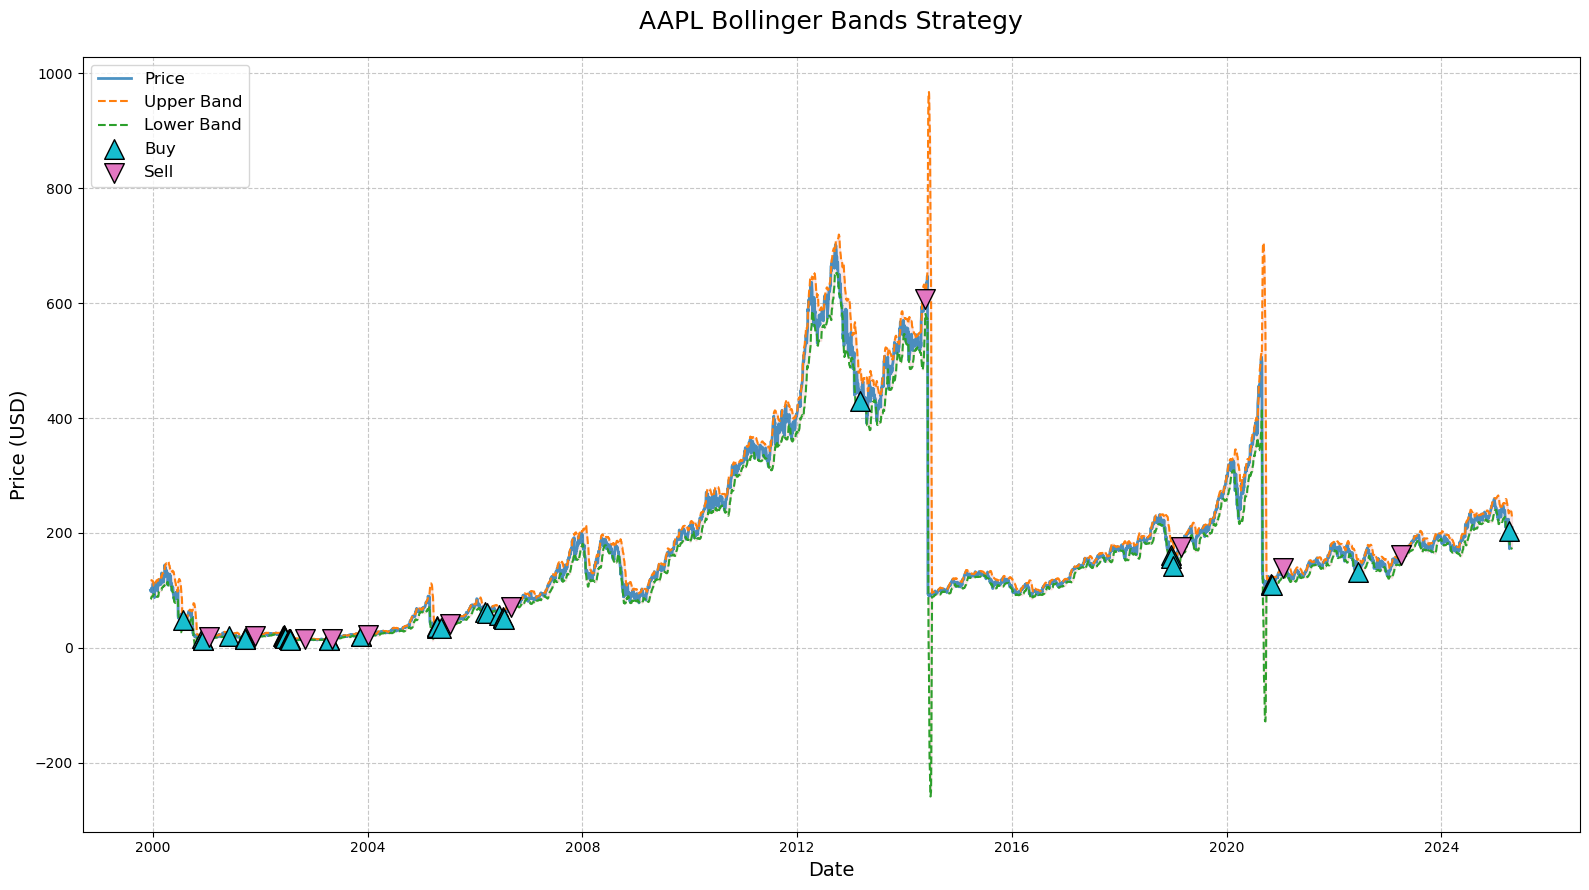

In [20]:
# 可视化主体
plt.figure(figsize=(16,9))
plt.plot(df['close'], label='Price', color='#1f77b4', lw=2, alpha=0.8)
plt.plot(df['upper_band'], '--', label='Upper Band', color='#ff7f0e')
plt.plot(df['lower_band'], '--', label='Lower Band', color='#2ca02c')
plt.fill_between(df.index, df['upper_band'], df['lower_band'],
                 color='#d62728', alpha=0.1)

if trades:
    trades_df = pd.DataFrame(trades)
    trades_df['time'] = pd.to_datetime(trades_df['time'])
    
    buy_signals = trades_df[trades_df['type']=='buy']
    sell_signals = trades_df[trades_df['type']=='sell']
    
    plt.scatter(buy_signals['time'], buy_signals['price'], 
                marker='^', color='#17becf', s=200, 
                edgecolors='black', label='Buy', zorder=4)
    plt.scatter(sell_signals['time'], sell_signals['price'], 
                marker='v', color='#e377c2', s=200,
                edgecolors='black', label='Sell', zorder=4)

plt.title('AAPL Bollinger Bands Strategy', fontsize=18, pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, ls='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 绩效可视化

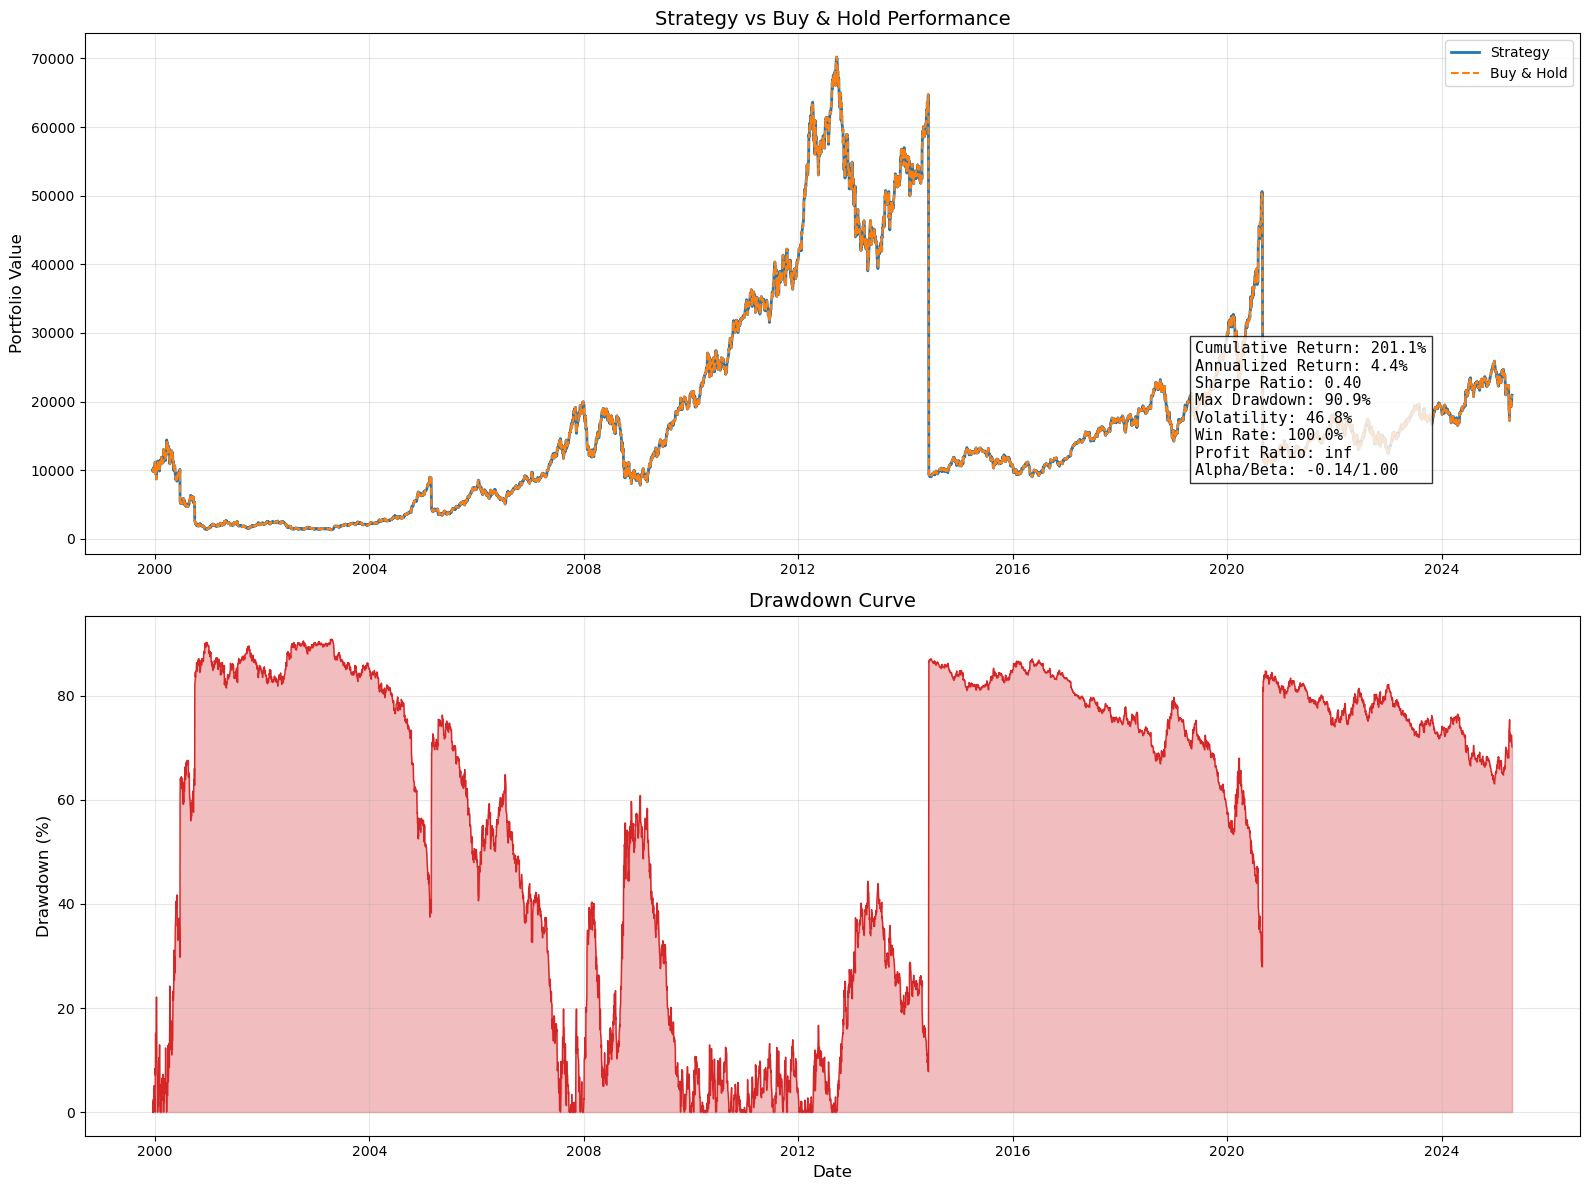

In [21]:

plt.figure(figsize=(16, 12))

# 资产曲线与基准对比
plt.subplot(2,1,1)
plt.plot(portfolio['total_value'], label='Strategy', color='#1f77b4', lw=2)
plt.plot(portfolio['close']/portfolio['close'].iloc[0]*initial_balance, 
         label='Buy & Hold', color='#ff7f0e', linestyle='--')
plt.title('Strategy vs Buy & Hold Performance', fontsize=14)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# 回撤曲线
plt.subplot(2,1,2)
plt.fill_between(drawdown.index, drawdown*100, color='#d62728', alpha=0.3)
plt.plot(drawdown*100, color='#d62728', lw=1)
plt.title('Drawdown Curve', fontsize=14)
plt.ylabel('Drawdown (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3)

# 添加指标表格
metrics_text = (
    f"Cumulative Return: {cumulative_return*100:.1f}%\n"
    f"Annualized Return: {annualized_return*100:.1f}%\n"
    f"Sharpe Ratio: {sharpe_ratio:.2f}\n"
    f"Max Drawdown: {max_drawdown*100:.1f}%\n"
    f"Volatility: {annualized_volatility*100:.1f}%\n"
    f"Win Rate: {win_rate*100:.1f}%\n"
    f"Profit Ratio: {profit_ratio:.2f}\n"
    f"Alpha/Beta: {alpha:.2f}/{beta:.2f}"
)
plt.figtext(0.75, 0.6, metrics_text, 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=11, family='monospace')

plt.tight_layout()
plt.show()